# 03 - Train and Deploy

In [2]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]


print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 441249477288
bucket: sagemaker-ap-south-1-441249477288
region: ap-south-1
role: arn:aws:iam::441249477288:role/service-role/AmazonSageMaker-ExecutionRole-20221207T104621


In [3]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import TensorBoardOutputConfig

In [7]:
dvc_repo_url = "codecommit::ap-south-1://sagemaker-intel"
dvc_branch = "processed-dataset"

In [8]:
tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path=f's3://{bucket}/sagemaker-intel-logs',
    container_local_output_path='/opt/ml/output/tensorboard'
)

In [ ]:
# pt_estimator = PyTorch(
#     base_job_name="training-intel-dataset",
#     entry_point="AWS-SageMaker/train.py",
#     role=get_execution_role(),
#     image_uri = "441249477288.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-training",
#     instance_count=1,
#     instance_type="ml.g4dn.xlarge",
#     # instance_type="ml.m5.4xlarge",
#     tensorboard_output_config=tensorboard_output_config,
#     use_spot_instances=True,
#     max_wait=1800,
#     max_run=1500,
#     environment={
#         "DVC_REPO_URL": dvc_repo_url,
#         "DVC_BRANCH": dvc_branch,
#         "GIT_USER": "gokul-pv",
#         "GIT_EMAIL": "25975535+gokul-pv@users.noreply.github.com"
#     }
# )

In [10]:
from sagemaker.estimator import Estimator

In [11]:
pt_estimator = Estimator(
    base_job_name="training-intel-dataset",
    image_uri = "441249477288.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-training",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    tensorboard_output_config=tensorboard_output_config,
    use_spot_instances=True,
    max_wait=1800,
    max_run=1500,
    environment={
        "DVC_REPO_URL": dvc_repo_url,
        "DVC_BRANCH": dvc_branch,
        "GIT_USER": "gokul-pv",
        "GIT_EMAIL": "25975535+gokul-pv@users.noreply.github.com"
    }

)

In [12]:
pt_estimator.fit()

2022-12-15 10:20:27 Starting - Starting the training job...
2022-12-15 10:20:42 Starting - Preparing the instances for trainingProfilerReport-1671099627: InProgress
............
2022-12-15 10:22:49 Downloading - Downloading input data...
2022-12-15 10:23:26 Training - Downloading the training image...............
2022-12-15 10:25:47 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
sed: can't read changehostname.c: No such file or directory
gcc: error: changehostname.c: No such file or directory
gcc: fatal error: no input files
compilation terminated.
gcc: error: changehostname.o: No such file or directory
ERROR: ld.so: object '/libchangehostname.so' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/libchangehostname.so' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
2022-12-1

## Deploy to Endpoint

In [41]:
from sagemaker.pytorch import PyTorchModel
# from sagemaker.model import Model
from sagemaker.serializers import JSONSerializer, NumpySerializer
from sagemaker.deserializers import JSONDeserializer

Get the `model_data` from the models uploaded to S3 of the aboved training

Once your debugging is done, it's better to simply call `pt_estimator.deploy`

In [42]:
model = PyTorchModel(
    model_data="s3://sagemaker-ap-south-1-441249477288/training-intel-dataset-2022-12-15-10-20-27-236/output/model.tar.gz",
    role=get_execution_role(),
    entry_point="infer.py",
    image_uri = "441249477288.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-inference",
    source_dir="AWS-SageMaker",
)

The files inside the docker image is cleared while spining up the endoint. Hence can not use the code cached inside docker image itself.
Refer: https://github.com/aws/sagemaker-pytorch-inference-toolkit/issues/61

In [5]:
# model = Model(
#     image_uri = "441249477288.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-inference",
#     model_data="s3://sagemaker-ap-south-1-441249477288/training-intel-dataset-2022-12-15-10-20-27-236/output/model.tar.gz",
#     role=get_execution_role(),
# )

In [43]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=NumpySerializer(),
    deserializer=JSONDeserializer(),
)

--------------!

## Predictor

Predictor is also not needed to be created again, but today we want to be verbose

In [44]:
# from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchPredictor

In [45]:
predictor_new = PyTorchPredictor(
    endpoint_name="sagemaker-inference-2022-12-16-10-10-26-139",
    sagemaker_session=sagemaker_session,
    serializer=NumpySerializer(),
    deserializer=JSONDeserializer(),
)

In [46]:
classnames = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [47]:
! wget -O building.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/UB_tower.jpg/1200px-UB_tower.jpg"

--2022-12-16 10:18:12--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/UB_tower.jpg/1200px-UB_tower.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349917 (342K) [image/jpeg]
Saving to: ‘building.jpg’

building.jpg        100%[===================>] 341.72K  1.47MB/s    in 0.2s    

2022-12-16 10:18:13 (1.47 MB/s) - ‘building.jpg’ saved [349917/349917]



In [48]:
from PIL import Image
import numpy

In [49]:
image = Image.open("building.jpg")

In [50]:
# image_input = {"inputs": data}
image_input = numpy.array(image)

If file is larger you will get 413 error. Refer https://github.com/aws/amazon-sagemaker-examples/issues/245

In [51]:
out = predictor_new.predict(image_input)

In [52]:
print(out)

{'buildings': 99.97463822364807, 'sea': 0.02128993801306933, 'street': 0.003234524410800077, 'mountain': 0.0006596953426196706, 'forest': 0.00019471308405627497}


Predicting on unseen images

In [55]:
! aws s3 cp s3://sagemaker-ap-south-1-441249477288/dataset/prediction/ . --recursive

download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/103.jpg to ./103.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/1801.jpg to ./1801.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/127.jpg to ./127.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/93.jpg to ./93.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/677.jpg to ./677.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/676.jpg to ./676.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/5.jpg to ./5.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/99.jpg to ./99.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/88.jpg to ./88.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/836.jpg to ./836.jpg
download: s3://sagemaker-ap-south-1-441249477288/dataset/prediction/499.jpg to ./499.jpg
download: s3://sagemaker-ap-s

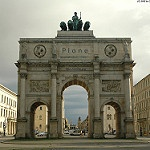

In [68]:
image = Image.open("103.jpg")
image.show()

In [69]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'buildings': 99.45735335350037, 'street': 0.3875919384881854, 'sea': 0.1237462623976171, 'glacier': 0.016304243763443083, 'forest': 0.007810606621205807}


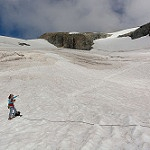

In [70]:
image = Image.open("127.jpg")
image.show()

In [71]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'glacier': 98.25275540351868, 'sea': 1.7352981492877007, 'mountain': 0.011574507516343147, 'forest': 0.00024987230062833987, 'buildings': 9.883700613499968e-05}


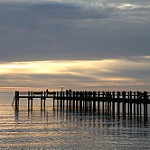

In [72]:
image = Image.open("1801.jpg")
image.show()

In [73]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'sea': 99.61276650428772, 'glacier': 0.19848847296088934, 'mountain': 0.13253767974674702, 'buildings': 0.04694797389674932, 'forest': 0.008523605356458575}


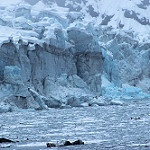

In [74]:
image = Image.open("499.jpg")
image.show()

In [75]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'sea': 60.69366931915283, 'mountain': 24.80875998735428, 'glacier': 7.820954918861389, 'forest': 5.911097675561905, 'buildings': 0.7260794285684824}


Misclassification

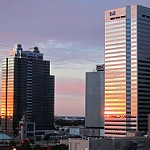

In [76]:
image = Image.open("5.jpg")
image.show()

In [77]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'buildings': 99.99934434890747, 'street': 0.00043415111576905474, 'sea': 0.0001663039370214392, 'mountain': 6.0855211359012173e-05, 'glacier': 4.32162465813235e-06}


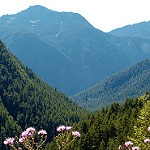

In [78]:
image = Image.open("676.jpg")
image.show()

In [79]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'buildings': 84.71586108207703, 'mountain': 14.851728081703186, 'sea': 0.35363202914595604, 'street': 0.05790067370980978, 'forest': 0.01642192219151184}


Misclassified

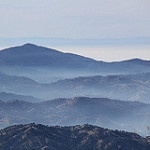

In [80]:
image = Image.open("677.jpg")
image.show()

In [81]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'mountain': 99.98681545257568, 'buildings': 0.007198887760750949, 'sea': 0.0029902443202445284, 'forest': 0.002327488073206041, 'glacier': 0.0006328074505290715}


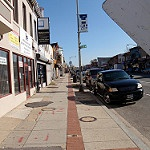

In [82]:
image = Image.open("69.jpg")
image.show()

In [83]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'buildings': 96.28375172615051, 'street': 3.601241111755371, 'sea': 0.05410413723438978, 'glacier': 0.03452954697422683, 'mountain': 0.013499564374797046}


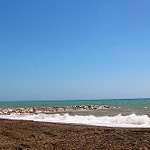

In [84]:
image = Image.open("836.jpg")
image.show()

In [85]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'sea': 99.98096823692322, 'mountain': 0.01868299877969548, 'buildings': 0.00014893381603542366, 'forest': 8.16276838122576e-05, 'street': 5.8829095905821305e-05}


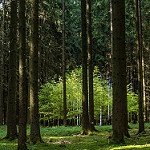

In [86]:
image = Image.open("88.jpg")
image.show()

In [87]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'forest': 87.06710934638977, 'buildings': 12.86061704158783, 'street': 0.04436956951394677, 'sea': 0.016566958220209926, 'mountain': 0.0068877059675287455}


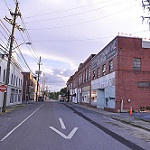

In [88]:
image = Image.open("93.jpg")
image.show()

In [89]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'street': 99.96448755264282, 'buildings': 0.03549116663634777, 'mountain': 8.872173395957361e-06, 'forest': 7.30199118947894e-06, 'sea': 3.6891368182523365e-06}


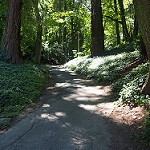

In [90]:
image = Image.open("99.jpg")
image.show()

In [91]:
image_input = numpy.array(image)
out = predictor_new.predict(image_input)
print(out)

{'forest': 99.29417371749878, 'buildings': 0.6522915326058865, 'sea': 0.04118665819987655, 'street': 0.007336113776545972, 'glacier': 0.0032278425351250917}
